### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
from fastai.callbacks.tracker import SaveModelCallback
from fastai.vision import *
from fastai.callbacks.hooks import *
import imageio
import numpy as np

# import torch

# torch.cuda.set_device(0)
# torch.cuda.get_device_name(0)

### Data paths

In [3]:
path = Path('/storage/data')
path_train_lbl = path/'training/1st_manual'
path_train_img = path/'training/images'
path_train_mask = path/'training/mask'
path_test_img = path/'test/images'
path_test_mask = path/'test/mask'
path_test_pred = path/'test/prediction'

### Data input processing

In [4]:
def normalize(img_file, path, t="training"):
    img = imageio.imread(img_file)
    number = img_file.name[:2]
    mask_file = path/("{}_{}_mask.gif".format(number, t))
    mask = imageio.imread(mask_file)
    
    std_mask = mask // 255
    rgb_mask = np.expand_dims(std_mask, axis=2).repeat(3,2)
    img1 = img * rgb_mask

    n = 584 * 564
    n_mask = std_mask.sum()

    means = [np.mean(img1[:,:,i]) * n/n_mask for i in range(0,3)]
    stds = [np.sqrt(np.sum(np.square((img1[:,:,i] - means[i]) * std_mask))/ n_mask) for i in range(0,3)]

    target_means = [171.2195, 112.2252, 65.1045]
    target_stds = [30.9084, 19.4734, 10.7638]
    
    for i in range(0,3):
        img1[:,:,i] = ((((img1[:,:,i] - means[i]) / stds[i]) * target_stds[i])+ target_means[i]) * std_mask 
    img1 = np.clip(img1, 0, 255)
    
    imageio.imwrite(img_file, img1)

def encode_label(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if np.amax(img) == 255:
        img = img // 255
        imageio.imwrite(file_name, img)
    
    #print(file_name, img.shape, np.amax(img))

def decode_label(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if np.amax(img) == 1:
        img = img * 255
        imageio.imwrite(file_name, img)
    
    #print(file_name, img.shape, np.amax(img))

def undo_crop(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if img_width%2 == 0:
        if channel_dim == 1:
            new_img = np.zeros((img_height, img_width + 1), dtype=np.uint8)
            new_img[:,:-1] = img
        else:
            new_img = np.zeros((img_height, img_width + 1, img.shape[2]), dtype=np.uint8)
            new_img[:,:-1,:] = img            
        img = new_img
        imageio.imwrite(file_name, img)
    
    #print(file_name, img.shape)

def crop_even(file_name):
    img = imageio.imread(file_name)
    channel_dim = 1 if len(img.shape) == 2 else 3
    img_height, img_width = img.shape[0], img.shape[1]
    if img_width%2 == 1:
        if channel_dim == 1:
            img = img[:,:-1]
        else:
            img = img[:,:-1,:]            
        imageio.imwrite(file_name, img)
        
    #print(file_name, img.shape)

The following input preprocessing steps are necessary:
- Make sure that the width and heigth are even numbers
- The labels should have values 0 or 1

In [5]:
for file_name in path_train_mask.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)

for file_name in path_train_lbl.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        encode_label(file_name)

for file_name in path_train_img.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        normalize(file_name, path_train_mask)

for file_name in path_test_mask.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        
for file_name in path_test_img.ls():
    if file_name.suffix == '.gif' or file_name.suffix == '.tif':
        crop_even(file_name)
        normalize(file_name, path_test_mask, "test")


## Data

In [6]:
fnames = get_image_files(path_train_img)
fnames[:3]

[PosixPath('/storage/data/training/images/27_training.tif'),
 PosixPath('/storage/data/training/images/28_training.tif'),
 PosixPath('/storage/data/training/images/31_training.tif')]

In [11]:
lbl_names = get_image_files(path_train_lbl)
lbl_names[:3]

[PosixPath('/storage/data/training/1st_manual/26_manual1.gif'),
 PosixPath('/storage/data/training/1st_manual/35_manual1.gif'),
 PosixPath('/storage/data/training/1st_manual/24_manual1.gif')]

### Show a sample of the images and the labels

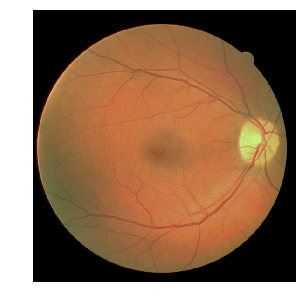

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))
src_size = np.array(img.shape[1:])

In [8]:
get_y_fn = lambda x: path_train_lbl/f'{x.parts[-1].split("_")[0]}_manual1.gif'

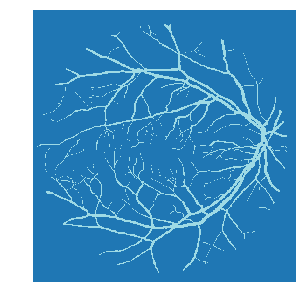

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

### Load the text labels for the label values

In [10]:
codes = np.loadtxt(path/'training/codes.txt', dtype=str); codes

array(['Background', 'Artery'], dtype='<U10')

In [11]:
tfms = get_transforms(flip_vert=True, max_rotate=12.5, max_zoom=1.10, max_lighting=0.15, max_warp=0., p_affine=0.0, p_lighting=0.6, xtra_tfms=[contrast(scale=(2, 2))])

## Evaluation metric

In [12]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = 9

def dice(pred, target):
    smooth = 1.
   
    # have to use contiguous since they may from a torch.view op
    iflat = pred.argmax(dim=1).contiguous().view(pred.shape[0], -1)
    tflat = target.squeeze(dim=1).contiguous().view(target.shape[0], -1)
    
    intersection = torch.sum(iflat * tflat, dim=1, dtype=torch.float)
    union = torch.sum(tflat + iflat, dim=1, dtype=torch.float)
    
    return ((2. * intersection) / (union + smooth)).mean()

## Create datasets

In [13]:
src = (SegmentationItemList.from_folder(path_train_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
size = src_size//2
bs=2
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

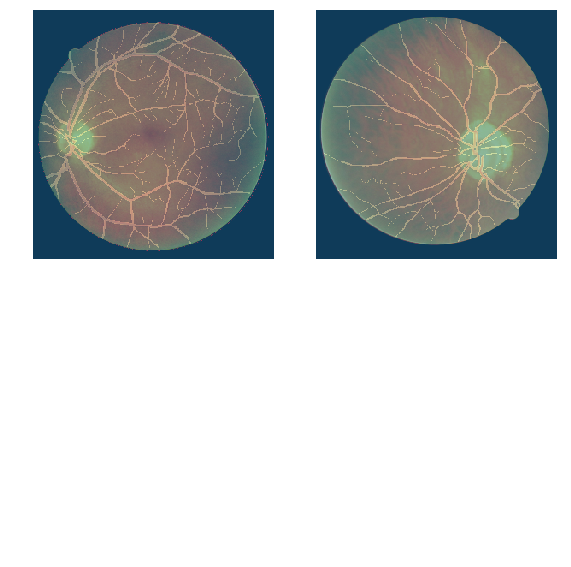

In [15]:
data.show_batch(bs, ds_type=DatasetType.Train)

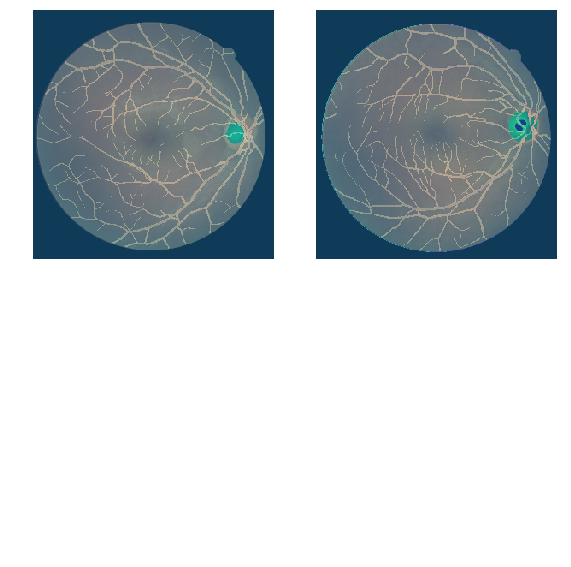

In [16]:
data.show_batch(bs, ds_type=DatasetType.Valid)

## Create U-Net Model

In [17]:
metrics=dice
wd=1e-3
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 19641635.76it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


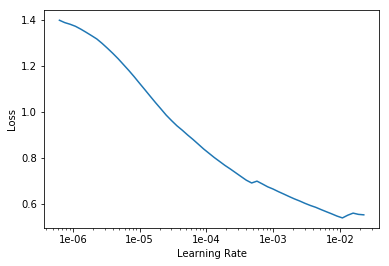

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr=1e-3

In [20]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice
1,0.554968,0.311455,0.000000
2,0.411816,0.287948,0.000070
3,0.356646,0.263432,0.015611
4,0.317937,0.210463,0.019770
5,0.287728,0.188070,0.353575
6,0.261625,0.167818,0.530209
7,0.240767,0.194344,0.641707
8,0.222614,0.146481,0.578115
9,0.207124,0.138223,0.639741
10,0.193993,0.136504,0.644922


In [21]:
learn.save('stage-1-18')

In [ ]:
learn.load('stage-1-50');

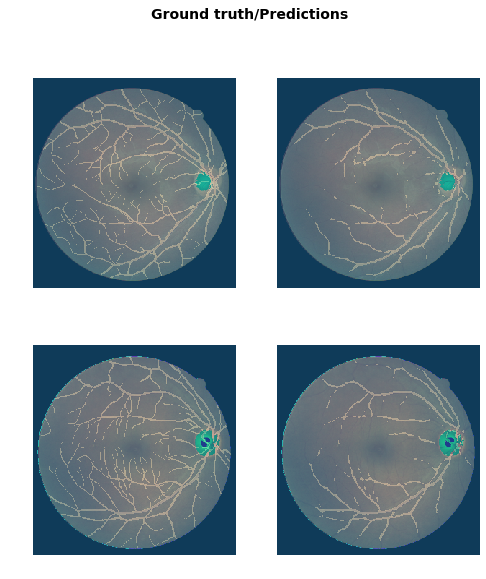

In [22]:
learn.show_results(rows=3, figsize=(8,9))

In [23]:
learn.unfreeze()

In [24]:
lrs = slice(lr/1000,lr/10)

In [25]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice
1,0.132983,0.139237,0.675501
2,0.131809,0.150972,0.690051
3,0.130730,0.132655,0.674823
4,0.129441,0.141166,0.692422
5,0.128699,0.139798,0.694533
6,0.128406,0.129957,0.689291
7,0.128339,0.132169,0.696012
8,0.127096,0.126246,0.693809
9,0.126027,0.132327,0.708075
10,0.124821,0.133256,0.708352


In [26]:
learn.save('stage-2-18')

## Train a model on the original image size

In [27]:
src = (SegmentationItemList.from_folder(path_train_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [28]:
bs=2
data = (src.transform(tfms, size=src_size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [29]:
metrics=dice
wd=1e-3
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd).to_fp16()

In [ ]:
learn.load('stage-2-18')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


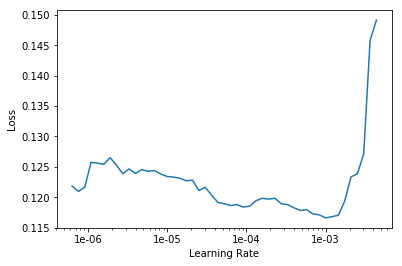

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lr=5e-4

In [33]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice
1,0.120172,0.124908,0.749669
2,0.114397,0.109328,0.748706
3,0.112118,0.109529,0.761388
4,0.111035,0.120008,0.770911
5,0.111619,0.106133,0.766888
6,0.110365,0.125156,0.768675
7,0.107890,0.131708,0.764254
8,0.106494,0.138128,0.749065
9,0.106119,0.100005,0.774923
10,0.104739,0.111382,0.773794


In [34]:
learn.save('stage-1-18-big')

In [ ]:
learn.load('stage-1-18-big')

In [44]:
learn.unfreeze()

In [45]:
lrs = slice(lr/100,lr/10)
learn.fit_one_cycle(50, lrs, callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name="model-18-1")])

epoch,train_loss,valid_loss,dice
1,0.095974,0.106639,0.777597
2,0.095512,0.101693,0.780333
3,0.095097,0.099833,0.781414
4,0.094725,0.102549,0.780041
5,0.094456,0.105514,0.777449
6,0.094090,0.102129,0.781535
7,0.093900,0.101245,0.781450
8,0.093704,0.101993,0.781594
9,0.093552,0.102208,0.781860
10,0.093274,0.099725,0.785023


In [46]:
lrs = slice(lr/1000,lr/100)
learn.load('model-18-1')
learn.fit_one_cycle(50, lrs, callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name="model-18-2")])

epoch,train_loss,valid_loss,dice
1,0.084972,0.093386,0.790785
2,0.084206,0.093483,0.790631
3,0.083912,0.095569,0.789626
4,0.084195,0.095721,0.789357
5,0.084018,0.096848,0.788822
6,0.083932,0.099594,0.787013
7,0.083904,0.098601,0.787356
8,0.083781,0.096090,0.789258
9,0.083760,0.096101,0.788958
10,0.084005,0.096737,0.788633


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


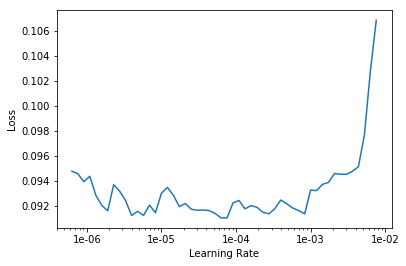

In [46]:
lr_find(learn)
learn.recorder.plot()

In [44]:
learn.save('stage-2-18-big')

## Create test predictions

In [45]:
metrics=dice
wd=1e-3
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2-18-big')

In [ ]:
for file_name in path_test_img.ls():
    print(file_name)
    idx = int(file_name.name[-11:-9])
    img = open_image(file_name)
    predict = learn.predict(contrast(img, scale=2))
    data = predict[1].transpose(0,2).transpose(0,1)
    out_file = path_test_pred/("{}.png".format(idx))
    imageio.imwrite(out_file.as_posix(), data.numpy())    

In [48]:
for file_name in path_test_pred.ls():
    undo_crop(file_name)
    decode_label(file_name)